In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.api import VAR
from var_model_toolkit import adfuller_test

In [46]:
def inflation_expectations(data):

    model = sm.tsa.ar_model.AutoReg(endog=data.dropna(),lags=12)
    return model.fit().forecast(120).mean()

def stock_return(current_earning_yeld, predicted_earning_yeld,epsgr,pay_out_ratio):
    delta_cape = ((predicted_earning_yeld**-1)/(current_earning_yeld**-1))**(1/10) -1
    div_yeld = predicted_earning_yeld*pay_out_ratio
    return delta_cape+epsgr+div_yeld

In [8]:
#usunięto ostatni rząd
df_source = pd.read_excel('ie_data.xlsx',sheet_name='Data', header=7, usecols=['Date','CAPE', 'Rate GS10', 'CPI', 'P', 'D', 'E'], parse_dates=True, index_col='Date')
df_source.index = pd.date_range(start='1871-01-01',end='2023-10-01',freq='M')
df_source.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1833 entries, 1871-01-31 to 2023-09-30
Freq: M
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   P          1833 non-null   float64
 1   D          1830 non-null   float64
 2   E          1830 non-null   float64
 3   CPI        1833 non-null   float64
 4   Rate GS10  1833 non-null   float64
 5   CAPE       1713 non-null   float64
dtypes: float64(6)
memory usage: 100.2 KB


In [9]:
df_source.tail(10)

,P,D,E,CPI,Rate GS10,CAPE
2022-12-31,3912.380952,66.920000,172.750000,296.7970,3.62,28.316901
2023-01-31,3960.656500,67.350000,173.556667,299.1700,3.53,28.334813
2023-02-28,4079.684737,67.780000,174.363333,300.8400,3.75,28.919763
2023-03-31,3968.559130,68.210000,175.170000,301.6750,3.66,27.953041
2023-04-30,4121.467368,68.376667,177.170000,303.3630,3.46,28.764684
2023-05-31,4146.173182,68.543333,179.170000,304.1270,3.57,28.761806
2023-06-30,4345.372857,68.710000,181.170000,305.1090,3.75,29.939593
2023-07-31,4508.075500,NaN,NaN,305.6910,3.90,30.890926
2023-08-31,4457.358696,NaN,NaN,305.9820,4.17,30.469743
2023-09-30,4515.770000,NaN,NaN,306.1275,4.09,30.810961


In [61]:
data = pd.DataFrame({})
data['Price'] = df_source['P']
data['cape_inv'] = 1/df_source['CAPE']
data['cpi'] = df_source['CPI'].pct_change(periods=12).shift(2)
data['infl_expect'] = data['cpi'].rolling(361).apply(lambda x: inflation_expectations(x))
data['r10yb'] = df_source['Rate GS10']/100 - data['infl_expect']
data['eqvol'] = df_source['P'].pct_change().rolling(12).std()
data['bndyvol'] = df_source['Rate GS10'].rolling(12).std()
data['epsgr'] = (df_source['E']/df_source['E'].shift(240))**(1/20)-1
data['por'] = df_source['D']/df_source['E']
data['D'] = 0

#var_exog = np.log(var_exog)
np.round(data.tail(10),3)

,Price,cape_inv,cpi,infl_expect,r10yb,eqvol,bndyvol,epsgr,por,D
2022-12-31,3912.381,0.035,0.077,0.025,0.011,0.043,0.734,0.096,0.387,0
2023-01-31,3960.656,0.035,0.071,0.025,0.011,0.043,0.646,0.095,0.388,0
2023-02-28,4079.685,0.035,0.065,0.024,0.013,0.044,0.553,0.093,0.389,0
2023-03-31,3968.559,0.036,0.064,0.025,0.012,0.045,0.435,0.092,0.389,0
2023-04-30,4121.467,0.035,0.060,0.025,0.010,0.047,0.387,0.090,0.386,0
2023-05-31,4146.173,0.035,0.049,0.023,0.013,0.040,0.349,0.088,0.383,0
2023-06-30,4345.373,0.033,0.049,0.024,0.013,0.040,0.337,0.086,0.379,0
2023-07-31,4508.076,0.032,0.040,0.023,0.016,0.041,0.283,NaN,NaN,0
2023-08-31,4457.359,0.033,0.030,0.022,0.020,0.038,0.216,NaN,NaN,0
2023-09-30,4515.770,0.032,0.032,0.024,0.017,0.028,0.227,NaN,NaN,0


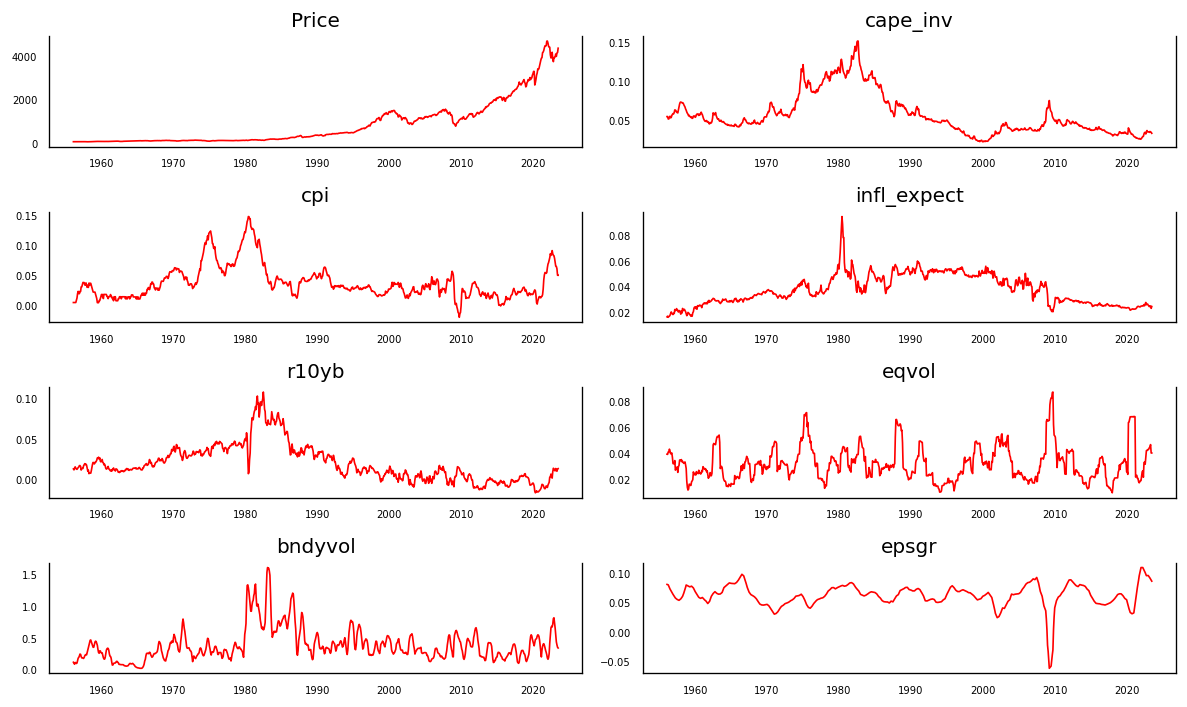

In [98]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data1 = data['1956-01-01':'2023-07-01'][data.columns[i]]
    ax.plot(data1, color='red', linewidth=1)
    # Decorations
    ax.set_title(data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

<AxesSubplot:>

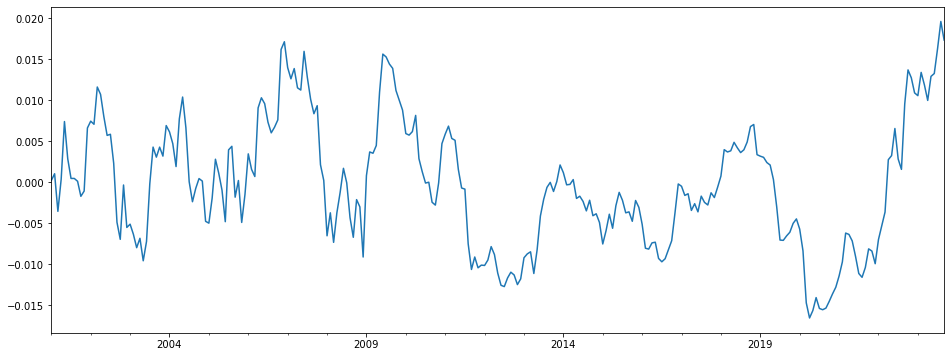

In [12]:
data['r10yb']['2001-01-01':].plot(figsize=(16,6))


var_exog: 
- cape_inv: 1/cape 
- r10yb: - Real 10-year bond yields (nominal yeld-expected inflation)
- cpi: Year-over-year CPI inflation rate
- eqvol: Realized S&P500 price volatility, over trailing 12 months,
- bndyvol: Realized volatility of changes in our real bond yield series, over trailing 12 months
'epsgr' - 10 year earnings return
por - pay-ot ratio

price - delta earngs + diwident yeld + delta valuation

In [14]:
def transform_variables_diff(data, const):
    
    transformed = np.log(data + const)
    transformed = transformed.diff()

    return transformed

def invert_transform_diff(forecast, constant, start_value):
    x = np.log(start_value+constant)
    inverted = x + forecast.cumsum()
    inverted = np.exp(inverted)
    return inverted


In [15]:
def transform_variables(data, const):
    
    transformed = np.log(data + const)
    
    return transformed

def invert_transform(forecast, constant):
    inverted = np.exp(forecast)-constant
    return inverted

In [57]:
exog_variables = ['cape_inv','r10yb','cpi','eqvol','bndyvol']
variables = data.loc['1925-12-01':,exog_variables]
const = np.array([0,0.025, 0.11, 0, 0])
variables = transform_variables(variables, const)
#train = variables['1926-01-01':'1960-01-01']
train = variables['1926-01-01':'1959-12-31']

var_model = VAR(train)
fitted = var_model.fit(12)

In [58]:
for name, column in train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "cape_inv" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 => P-Value = 0.287. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "r10yb" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 => P-Value = 0.1155. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "cpi" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "eqvol" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 => P-Value = 0.002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "bndyvol"

<AxesSubplot:>

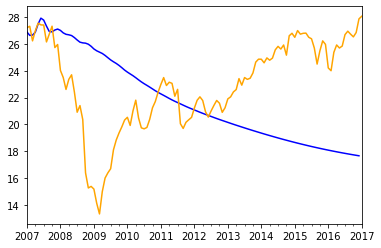

In [59]:
start_date = pd.to_datetime('2007-01-31')
start_input = start_date-pd.DateOffset(months=12)
input = variables.loc[start_input:start_date].values
forecast = fitted.forecast(input, steps=120)
forecast = pd.DataFrame(forecast, index=pd.date_range(start=start_date, freq='M', periods=120), columns=exog_variables)
forecast = invert_transform(forecast, const)

cape = forecast['cape_inv'].pow(-1)
cape.plot(color='blue')
test = data.loc[start_date:start_date+pd.DateOffset(months=120),'cape_inv']**-1
test.plot(color='orange')  



2000-01-31   -0.000254
2000-02-29   -0.002274
2000-03-31    0.000112
2000-04-30    0.000979
2000-05-31    0.003002
                ...   
2009-08-31   -0.000041
2009-09-30   -0.000042
2009-10-31   -0.000046
2009-11-30   -0.000043
2009-12-31   -0.000037

In [81]:
def var_forecast(training_data):
    var_model = VAR(training_data)
    fitted = var_model.fit(12)
    input = training_data.iloc[-13:-1].values
    forecast = fitted.forecast(input, steps=120)
    forecast = pd.DataFrame(forecast, columns=training_data.columns)
    forecast = invert_transform(forecast,const)
    return forecast

In [129]:
start_date = pd.to_datetime('1926-01-01')
forecast_dates = pd.date_range(start='1960-01-01',end='2013-06-30',freq='m')
forecasted_earnings_yelds = np.zeros(forecast_dates.shape[0])

for i in range(forecast_dates.shape[0]):  
    end_date = forecast_dates[i]
    start_date = start_date # end_date - pd.DateOffset(years=50) # 
    forecasted_earnings_yelds[i] = var_forecast(variables[start_date:end_date])['cape_inv'].iloc[-1] 



<AxesSubplot:>

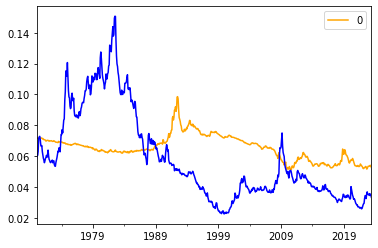

In [130]:
forecasted_earnings_yelds = pd.DataFrame(forecasted_earnings_yelds, index=pd.date_range(start='1970-01-01',end='2023-06-30',freq='m'))
forecasted_earnings_yelds.plot(color='orange')
data.loc['1970-01-01':'2023-06-30','cape_inv'].plot(color='blue')

<AxesSubplot:>

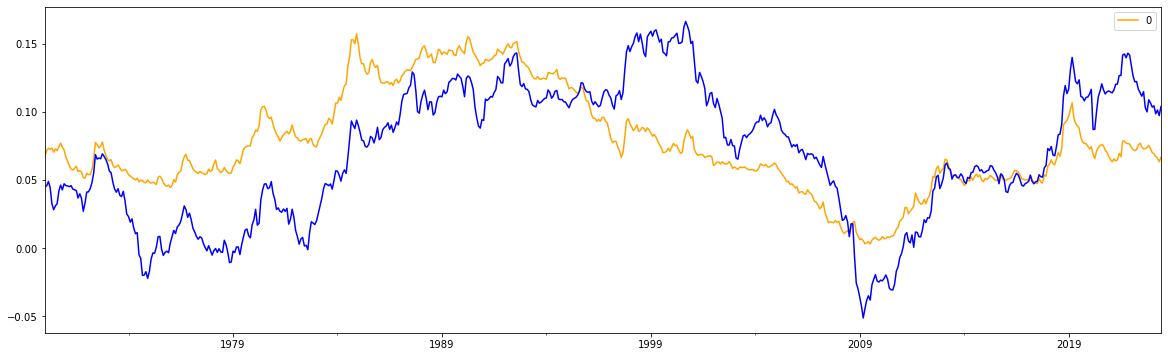

In [131]:
#predict stock returns
predicted_returns = np.zeros(forecast_dates.shape[0])
eps_growth = 0.06
pay_out_ratio=0.48

for i in range(forecast_dates.shape[0]):
    predicted_ey = forecasted_earnings_yelds.iloc[i]
    current_ey = data.loc[forecast_dates[i],'cape_inv']
    predicted_returns[i] = stock_return(current_ey,predicted_ey,eps_growth,pay_out_ratio)

predicted_returns = pd.DataFrame(predicted_returns,index=pd.date_range(start='1970-01-01',end='2023-06-30',freq='m'))
predicted_returns.plot(color='orange', figsize=(20,6))

acutal_returns = (data['Price']/data['Price'].shift(120))**(1/10)-1
acutal_returns[pd.date_range(start='1970-01-01',end='2023-06-30',freq='m')].plot(color='blue',figsize=(20,6))


In [30]:
(data.loc['1990-01-01':'2023-12-31','cape_inv']**-1).mean()

26.514763682409853

In [70]:
data.loc['1972-01-01':'2022-12-30','epsgr'].mean()

0.06122328608784753

In [37]:
data.loc['1976-01-01':'2023-06-30','por'].mean()

0.48684026696244637

In [21]:
epsgr = 0.05
dy = 0.015
delta_cape = -0.013
epsgr+dy+delta_cape

0.052000000000000005

In [40]:
1.9**(1/10)-1


0.06629005847852576

In [45]:


stock_return(1/30,1/25,0.06, 0.5)

0.06193304456191266

- predict annulazed 10y stock return
- prediction start date (1970) to current length - forecast array
- dla kazdego meisiaca:
  - predict cape 10y, based on trained data - expanded window
  - calculate stock return 

- test - 10 y annualized return
- calculate rmse